**Importing** **Libraries**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import ipywidgets as widgets
from ipywidgets import interact, fixed
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, HTML
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)

# Enable interactive plots for Plotly
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [2]:
# Load the dataset
df = pd.read_csv('/content/eCommerce_Customer_support_data.csv')

# Display basic information
print(f"Dataset Shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Dataset Shape: (49700, 20)
Number of rows: 49700
Number of columns: 20


In [3]:
# Display the first few rows of the dataset
df.head()

,Unique id,channel_name,category,Sub-category,Customer Remarks,Order_id,order_date_time,Issue_reported at,issue_responded,Survey_response_Date,Customer_City,Product_category,Item_price,connected_handling_time,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,NaN,NaN,NaN,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5.0
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,NaN,NaN,NaN,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5.0
2,200814dd-27c7-4149-ba2b-bd3af3092880,Inbound,Order Related,Installation/demo,NaN,c273368d-b961-44cb-beaf-62d6fd6c00d5,NaN,01/08/2023 20:16,01/08/2023 20:38,01-Aug-23,NaN,NaN,NaN,NaN,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5.0
3,eb0d3e53-c1ca-42d3-8486-e42c8d622135,Inbound,Returns,Reverse Pickup Enquiry,NaN,5aed0059-55a4-4ec6-bb54-97942092020a,NaN,01/08/2023 20:56,01/08/2023 21:16,01-Aug-23,NaN,NaN,NaN,NaN,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5.0
4,ba903143-1e54-406c-b969-46c52f92e5df,Inbound,Cancellation,Not Needed,NaN,e8bed5a9-6933-4aff-9dc6-ccefd7dcde59,NaN,01/08/2023 10:30,01/08/2023 10:32,01-Aug-23,NaN,NaN,NaN,NaN,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5.0


In [4]:
# Check column data types
df.dtypes

,0
Unique id,object
channel_name,object
category,object
Sub-category,object
Customer Remarks,object
Order_id,object
order_date_time,object
Issue_reported at,object
issue_responded,object
Survey_response_Date,object


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
missing_pct = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_pct
})

missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False)

,Missing Values,Percentage
connected_handling_time,49495,99.587525
Customer_City,37943,76.344064
Product_category,37874,76.205231
Item_price,37869,76.195171
order_date_time,37863,76.183099
Customer Remarks,33139,66.678068
Order_id,15388,30.961771
Supervisor,1,0.002012
Manager,1,0.002012
Tenure Bucket,1,0.002012


**Expolatory** **Data** **Analysis**

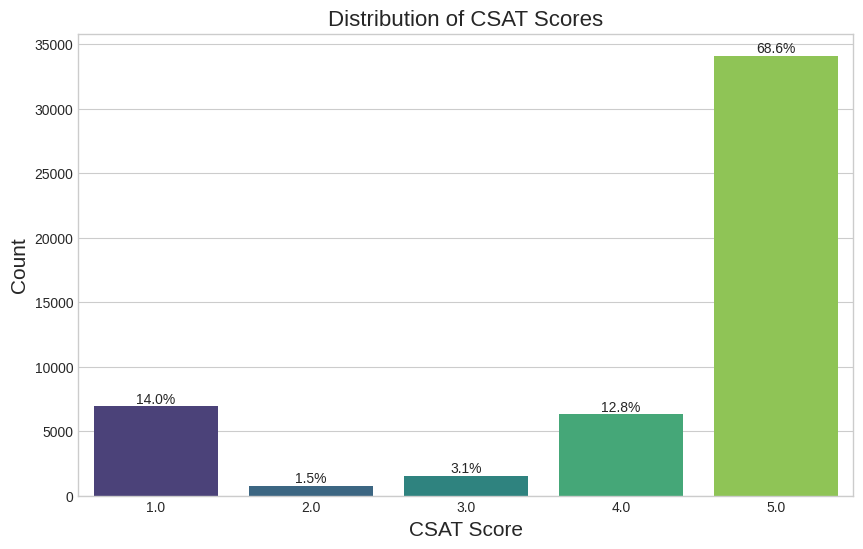

Average CSAT Score: 4.21


In [7]:
# CSAT Distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='CSAT Score', data=df.dropna(subset=['CSAT Score']), palette='viridis')

# Add percentage labels
total = len(df.dropna(subset=['CSAT Score']))
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.title('Distribution of CSAT Scores', fontsize=16)
plt.xlabel('CSAT Score', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

# Calculate average CSAT
avg_csat = df['CSAT Score'].mean()
print(f"Average CSAT Score: {avg_csat:.2f}")

**Parse** **DateTime** **Columns** **for** **Analysis**

In [8]:
# Function to parse different datetime formats
def parse_datetime(date_str):
    if pd.isna(date_str):
        return None
    try:
        # Try DD/MM/YYYY HH:MM format
        return datetime.strptime(date_str, '%d/%m/%Y %H:%M')
    except:
        try:
            # Try DD-MMM-YY format
            return datetime.strptime(date_str, '%d-%b-%y')
        except:
            return None

In [9]:
# Convert datetime columns
datetime_cols = ['order_date_time', 'Issue_reported at', 'issue_responded', 'Survey_response_Date']
for col in datetime_cols:
    if col in df.columns:
        df[col + '_parsed'] = df[col].apply(parse_datetime)

In [10]:
# Calculate response time in minutes
df['response_time_minutes'] = None
mask = (~df['Issue_reported at_parsed'].isna()) & (~df['issue_responded_parsed'].isna())
df.loc[mask, 'response_time_minutes'] = (
    (df.loc[mask, 'issue_responded_parsed'] - df.loc[mask, 'Issue_reported at_parsed'])
    .dt.total_seconds() / 60
)

In [11]:
 #Remove outliers in response time
df = df[(df['response_time_minutes'].isna()) | ((df['response_time_minutes'] >= 0) & (df['response_time_minutes'] <= 1000))]

# Fill missing response times with median
df['response_time_minutes'] = df['response_time_minutes'].fillna(df['response_time_minutes'].median())

Analyze CSAT by Channel

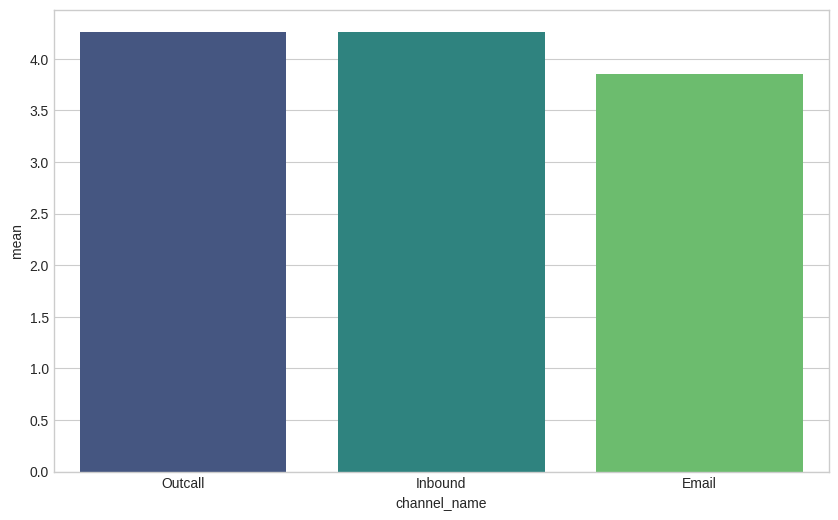

In [12]:
# CSAT by Channel
channel_csat = df.groupby('channel_name')['CSAT Score'].agg(['mean', 'count']).reset_index()
channel_csat = channel_csat.sort_values('mean', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='channel_name', y='mean', data=channel_csat, palette='viridis')


**Average** **CSAT score** **By** **Response** **Time**

In [13]:
# Bin response times for better visualization
df['response_time_bin'] = pd.cut(
    df['response_time_minutes'],
    bins=[0, 10, 20, 30, 60, 120, 240, 1000],
    labels=['0-10 min', '10-20 min', '20-30 min', '30-60 min', '1-2 hours', '2-4 hours', '4+ hours']
)


In [14]:
# Calculate average CSAT by response time bin
response_time_csat = df.groupby('response_time_bin')['CSAT Score'].agg(['mean', 'count']).reset_index()


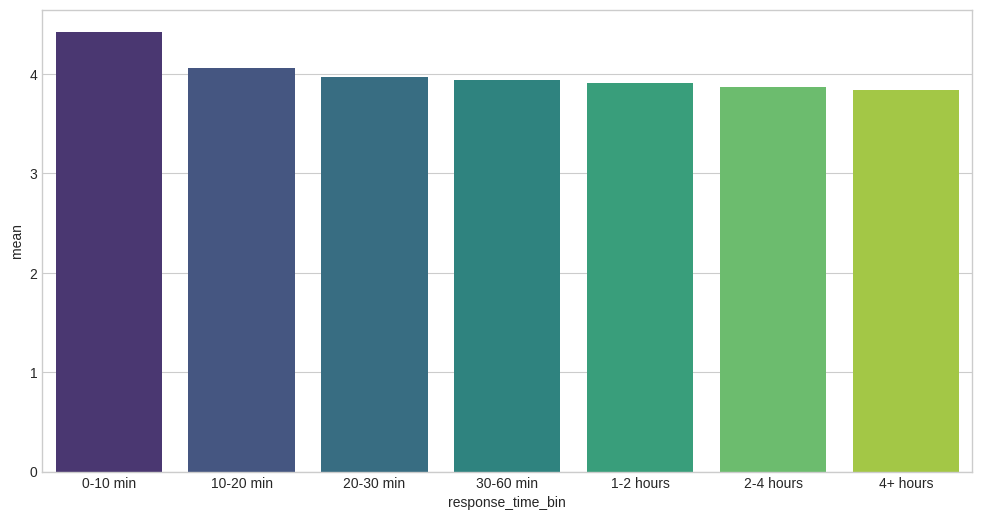

In [15]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='response_time_bin', y='mean', data=response_time_csat, palette='viridis')


In [16]:
# Calculate correlation between response time and CSAT
response_time_corr = df[['response_time_minutes', 'CSAT Score']].dropna().corr().iloc[0,1]
print(f"Correlation between response time and CSAT Score: {response_time_corr:.4f}")

Correlation between response time and CSAT Score: -0.1067


**Anayze CSAT** **by** **Category**

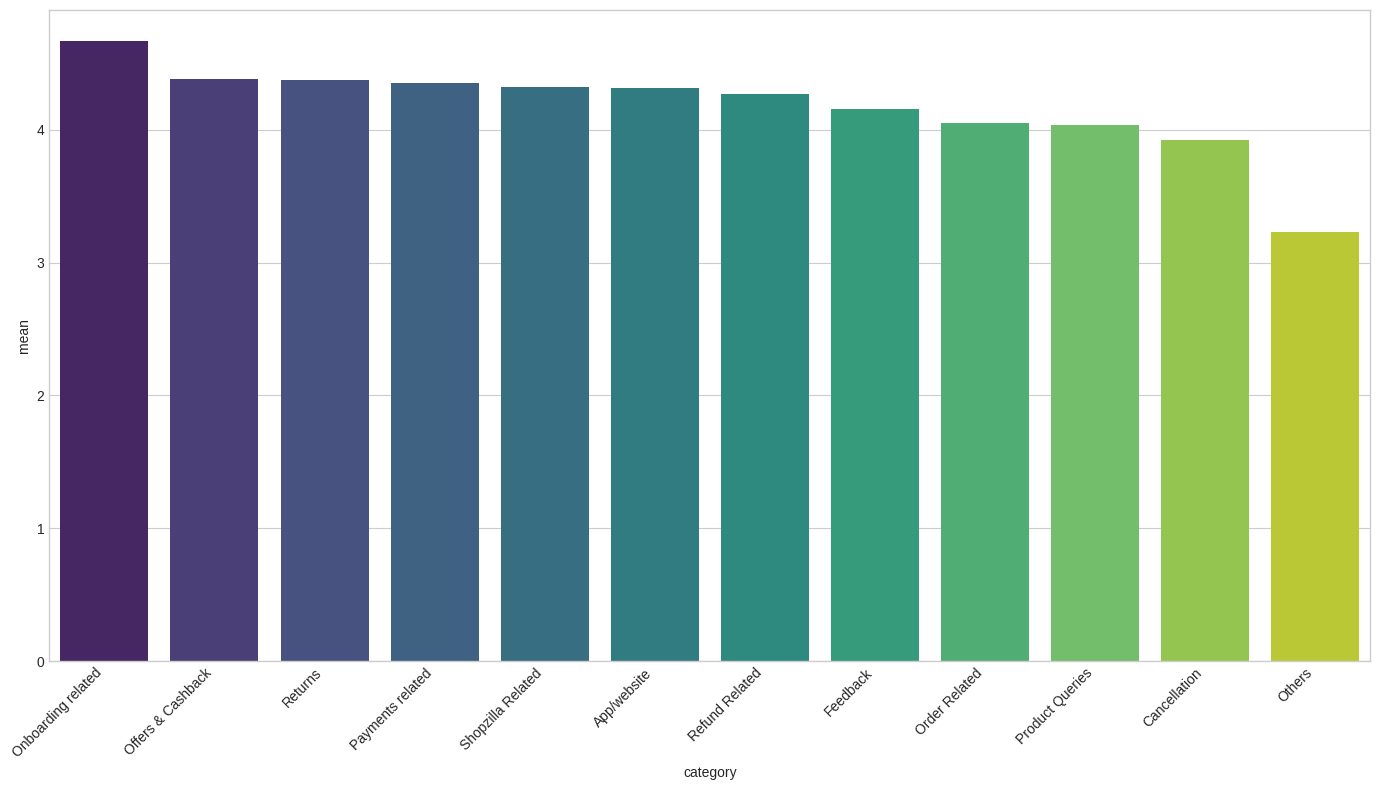

In [20]:
# Calculate average CSAT by category
category_csat = df.groupby('category')['CSAT Score'].agg(['mean', 'count']).reset_index()
category_csat = category_csat.sort_values('mean', ascending=False)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='category', y='mean', data=category_csat, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Anayze** **CSAT** **by** **Agent** **Tenure**

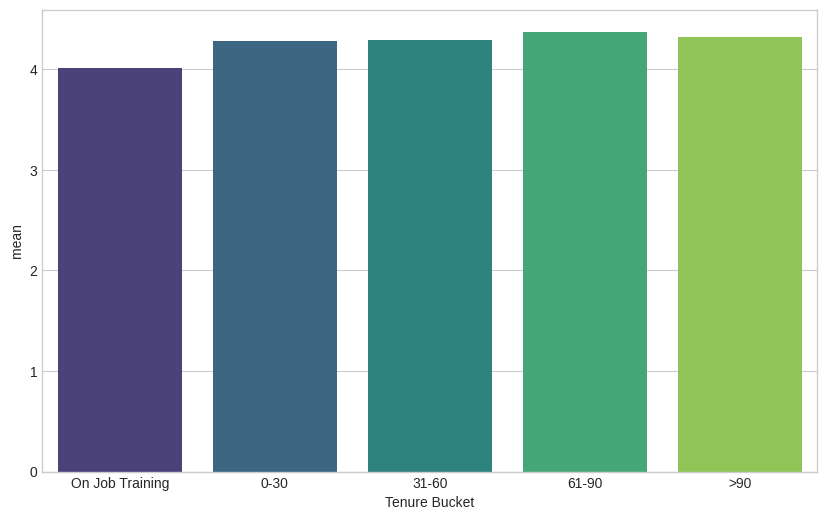

In [18]:
# Calculate average CSAT by tenure bucket
tenure_csat = df.groupby('Tenure Bucket')['CSAT Score'].agg(['mean', 'count']).reset_index()

# Custom sort order for tenure buckets
tenure_order = {'On Job Training': 0, '0-30': 1, '31-60': 2, '61-90': 3, '>90': 4}
tenure_csat['order'] = tenure_csat['Tenure Bucket'].map(tenure_order)
tenure_csat = tenure_csat.sort_values('order')

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Tenure Bucket', y='mean', data=tenure_csat, palette='viridis', order=tenure_csat['Tenure Bucket'])


**CSAT** **by** **Product** **Category**

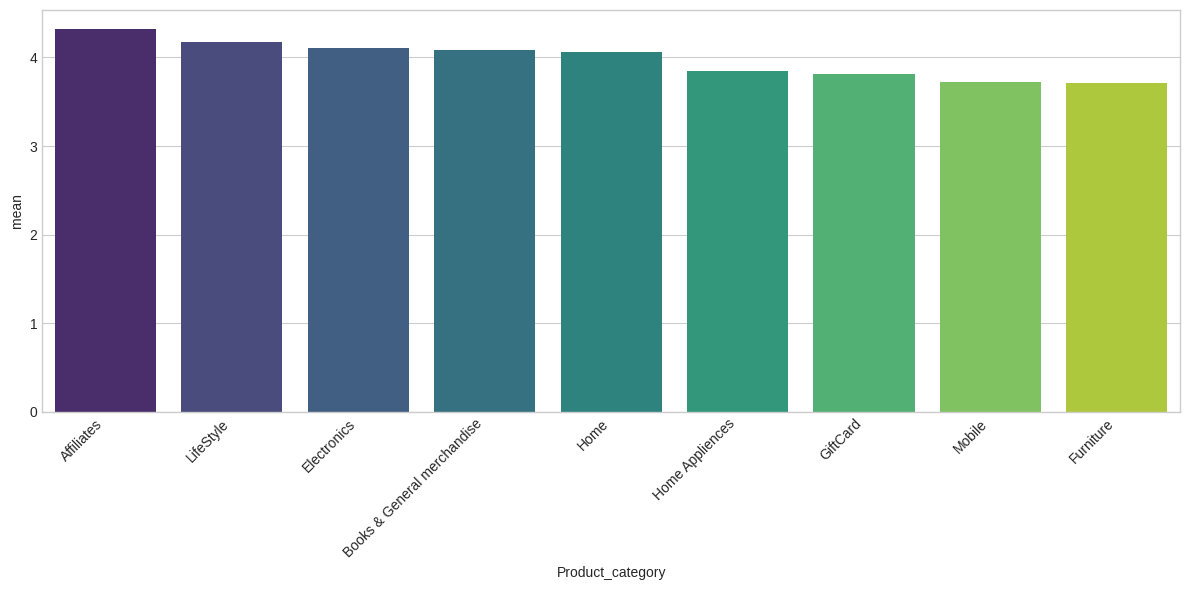

In [22]:
# Calculate average CSAT by product category
product_csat = df.dropna(subset=['Product_category']).groupby('Product_category')['CSAT Score'].agg(['mean', 'count']).reset_index()
product_csat = product_csat.sort_values('mean', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Product_category', y='mean', data=product_csat, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Data Preprocessing AND Training Model**

In [25]:
# Handle missing values
# For categorical columns, fill missing values with 'Unknown'
categorical_cols = ['channel_name', 'category', 'Sub-category', 'Customer_City',
                   'Product_category', 'Tenure Bucket', 'Agent Shift']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# For numerical columns that we'll use, fill with median
numerical_cols = ['Item_price', 'connected_handling_time', 'response_time_minutes']
for col in numerical_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

In [26]:
# Select relevant features for the model
features = [
    'channel_name', 'category', 'Sub-category', 'Product_category',
    'Item_price', 'connected_handling_time', 'Tenure Bucket', 'Agent Shift',
    'response_time_minutes'
]

# Filter out rows with missing CSAT scores
df_filtered = df.dropna(subset=['CSAT Score'])

# Prepare X and y
X = df_filtered[features]
y = df_filtered['CSAT Score'].astype(int) - 1  # Convert 1-5 to 0-4 for categorical crossentropy

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Define categorical and numerical features for preprocessing
categorical_features = ['channel_name', 'category', 'Sub-category', 'Product_category', 'Tenure Bucket', 'Agent Shift']
numerical_features = ['Item_price', 'connected_handling_time', 'response_time_minutes']

# Create preprocessing steps
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

# Fit and transform the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# One-hot encode the target
y_train_encoded = to_categorical(y_train, num_classes=5)
y_test_encoded = to_categorical(y_test, num_classes=5)

# Print preprocessed data shape
print(f"Preprocessed Training Data Shape: {X_train_preprocessed.shape}")
print(f"Preprocessed Testing Data Shape: {X_test_preprocessed.shape}")

Preprocessed Training Data Shape: (37615, 94)
Preprocessed Testing Data Shape: (9404, 94)


**Deep Learning Model Building**


In [28]:
# Get the input dimension
input_dim = X_train_preprocessed.shape[1]

# Create a model with multiple hidden layers
def create_model(input_dim):
    model = Sequential([
        # Input layer
        Dense(128, input_dim=input_dim, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Hidden layers
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer (5 classes for CSAT 1-5)
        Dense(5, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and summarize the model
model = create_model(input_dim)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        12,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,557 (92.02 KB)

 Trainable params: 23,109 (90.27 KB)

 Non-trainable params: 448 (1.75 KB)

**Model Traning**

In [29]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_csat_model.h5',
    monitor='val_accuracy',
    save_best_only=True
)

# Train the model
history = model.fit(
    X_train_preprocessed, y_train_encoded,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/50
937/941 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5032 - loss: 1.3975

941/941 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.5038 - loss: 1.3962 - val_accuracy: 0.6961 - val_loss: 0.9316
Epoch 2/50
934/941 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6927 - loss: 0.9480

941/941 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6927 - loss: 0.9480 - val_accuracy: 0.6969 - val_loss: 0.9231
Epoch 3/50
941/941 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6928 - loss: 0.9364 - val_accuracy: 0.6969 - val_loss: 0.9255
Epoch 4/50
941/941 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6956 - loss: 0.9239 - val_accuracy: 0.6967 - val_loss: 0.9229
Epoch 5/50
931/941 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6989 - loss: 0.9181

941/941 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6988 - loss: 0.9181 - val_accuracy: 0.6976 - val_loss: 0.9199
Epoch 6/50
941/941 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6963 - loss: 0.9227 - val_accuracy: 0.6967 - val_loss: 0.9187
Epoch 7/50
941/941 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6967 - loss: 0.9178 - val_accuracy: 0.6971 - val_loss: 0.9164
Epoch 8/50
941/941 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6976 - loss: 0.9167 - val_accuracy: 0.6968 - val_loss: 0.9159
Epoch 9/50
936/941 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6968 - loss: 0.9131

941/941 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6968 - loss: 0.9131 - val_accuracy: 0.6980 - val_loss: 0.9207
Epoch 10/50
941/941 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6965 - loss: 0.9122 - val_accuracy: 0.6972 - val_loss: 0.9196
Epoch 11/50
941/941 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6960 - loss: 0.9119 - val_accuracy: 0.6979 - val_loss: 0.9130
Epoch 12/50
941/941 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6968 - loss: 0.9091 - val_accuracy: 0.6972 - val_loss: 0.9152
Epoch 13/50
941/941 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6979 - loss: 0.9064 - val_accuracy: 0.6977 - val_loss: 0.9152
Epoch 14/50
941/941 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6940 - loss: 0.9123 - val_accuracy: 0.6971 - val_loss: 0.9141
Epoch 15/50
941/941 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6959 - loss: 0.9126 - val_accuracy: 0.6976 - val_loss: 0.9147
Epoch 16/50
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6914 - loss: 0.9170

941/941 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6914 - loss: 0.9170 - val_accuracy: 0.6987 - val_loss: 0.9143
Epoch 17/50
941/941 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7005 - loss: 0.8968 - val_accuracy: 0.6961 - val_loss: 0.9184
Epoch 18/50
941/941 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6963 - loss: 0.9111 - val_accuracy: 0.6979 - val_loss: 0.9159
Epoch 19/50
941/941 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6987 - loss: 0.9019 - val_accuracy: 0.6973 - val_loss: 0.9180
Epoch 20/50
941/941 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6956 - loss: 0.9018 - val_accuracy: 0.6983 - val_loss: 0.9155
Epoch 21/50
941/941 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6965 - loss: 0.9014 - val_accuracy: 0.6967 - val_loss: 0.9204


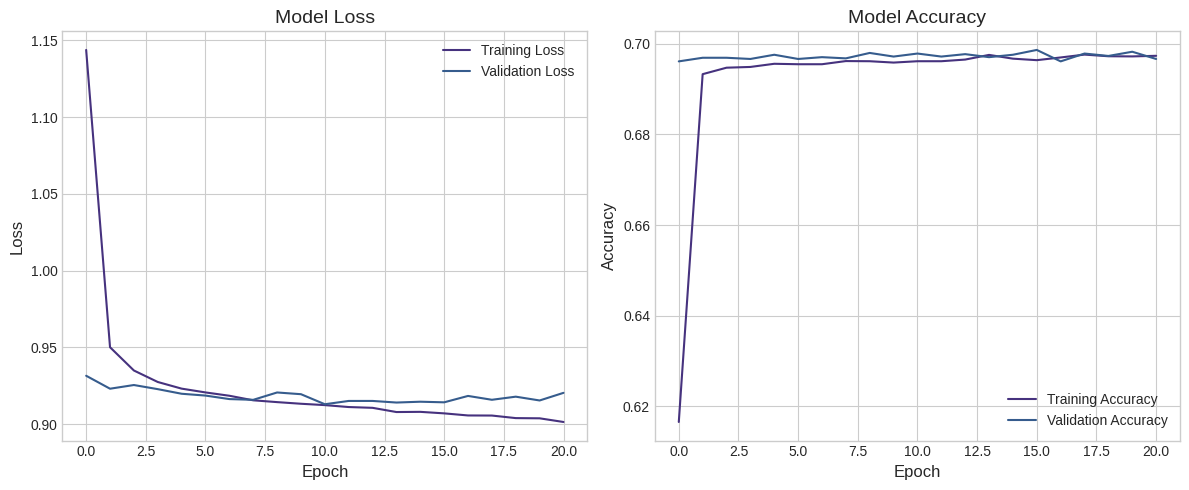

In [30]:
# Visualize training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

**Model Evaluation**

In [31]:
# Load the best model (optional if using callbacks)
try:
    model = tf.keras.models.load_model('best_csat_model.h5')
    print("Loaded the best model from checkpoint.")
except:
    print("Using the last model from training.")

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

Loaded the best model from checkpoint.
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7035 - loss: 0.9024

Test Accuracy: 0.6958


In [32]:
# Get predictions
y_pred_probabilities = model.predict(X_test_preprocessed)
y_pred = np.argmax(y_pred_probabilities, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Classification report
print("Classification Report:")
class_report = classification_report(y_true, y_pred, target_names=['CSAT 1', 'CSAT 2', 'CSAT 3', 'CSAT 4', 'CSAT 5'])
print(class_report)

294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Classification Report:
              precision    recall  f1-score   support

      CSAT 1       0.46      0.04      0.08      1257
      CSAT 2       0.00      0.00      0.00       114
      CSAT 3       0.00      0.00      0.00       300
      CSAT 4       0.00      0.00      0.00      1197
      CSAT 5       0.70      0.99      0.82      6536

    accuracy                           0.70      9404
   macro avg       0.23      0.21      0.18      9404
weighted avg       0.55      0.70      0.58      9404



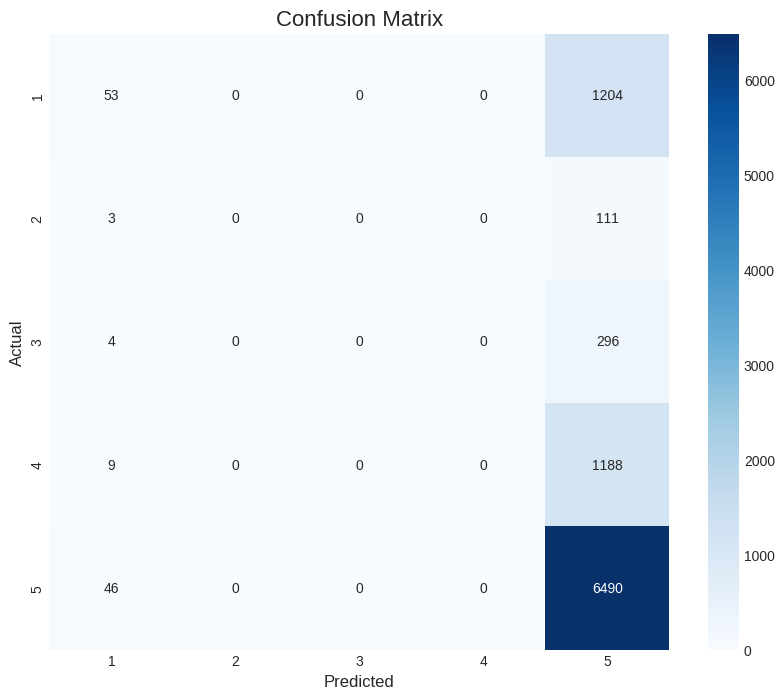

In [33]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1, 2, 3, 4, 5],
            yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

**Feature Importance Analysis**

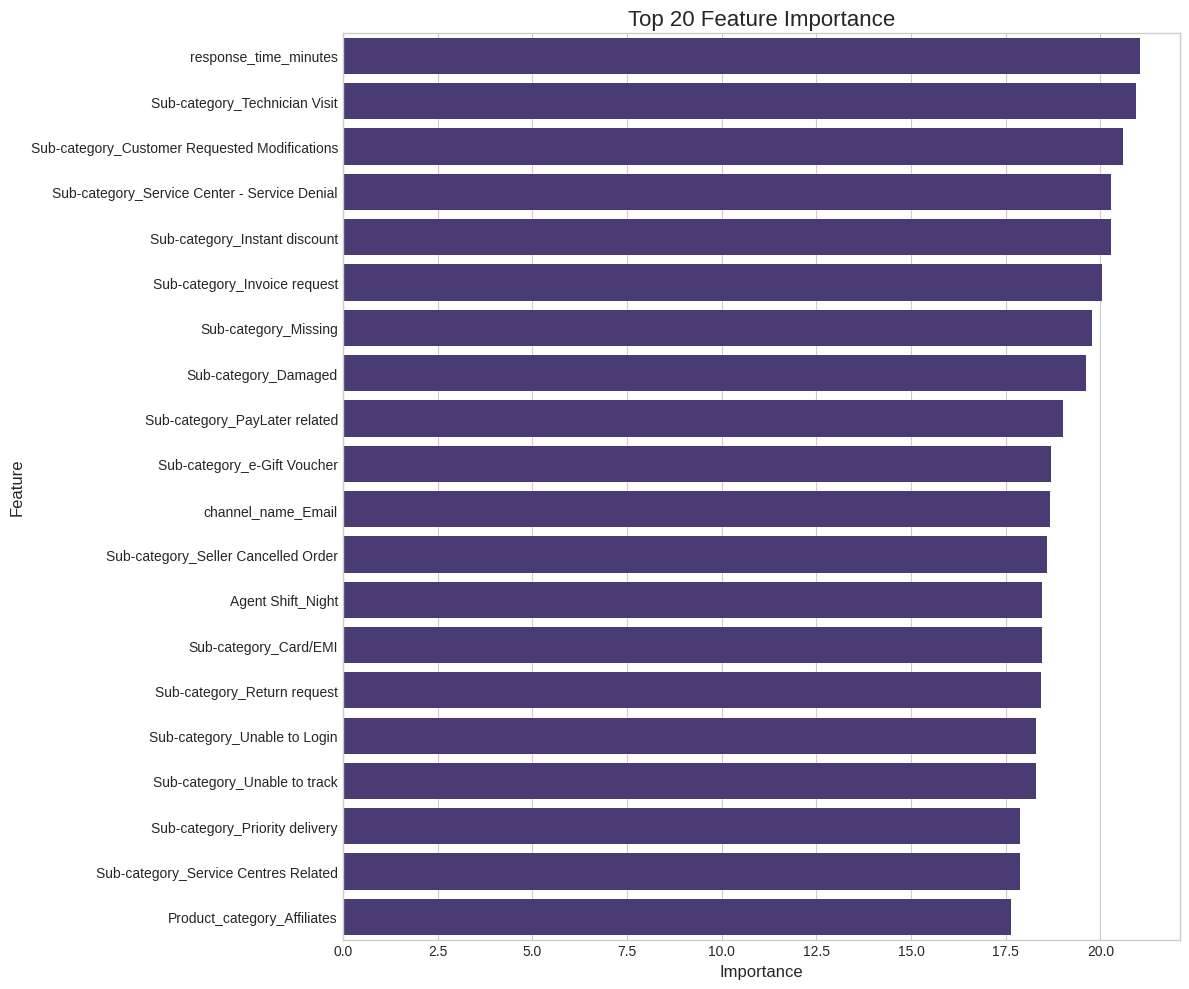

In [34]:
# Create a simpler model for feature importance - CORRECTED VERSION
# We only need the first layer weights for feature importance analysis

# Get the weights from the first layer of the original model
first_layer_weights = model.layers[0].get_weights()[0]

# Calculate feature importance directly
feature_importance = np.sum(np.abs(first_layer_weights), axis=1)

# Get feature names from the preprocessor
cat_features = []
for name, encoder, cols in preprocessor.transformers_:
    if name == 'cat':
        for i, col in enumerate(cols):
            for category in encoder.named_steps['onehot'].categories_[i]:
                cat_features.append(f"{col}_{category}")
    elif name == 'num':
        cat_features.extend(cols)

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': cat_features[:len(feature_importance)],
    'Importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

**Save Model and Preprocessor**

In [35]:
import joblib

# Save the preprocessor
joblib.dump(preprocessor, 'csat_preprocessor.joblib')

# Save the model with .keras extension (newer, recommended format)
model.save('deepcsat_model.keras')

print("saved successfully")

saved successfully


**Create** **Prediction** **Function**

In [36]:
def predict_csat(new_data, preprocessor, model):
    """
    Make CSAT predictions on new data.

    Parameters:
    new_data (pd.DataFrame): New data with the same feature columns as training data
    preprocessor: Fitted preprocessor
    model: Trained model

    Returns:
    np.array: Predicted CSAT scores (1-5)
    """
    # Preprocess the data
    X_new_preprocessed = preprocessor.transform(new_data)

    # Get predictions
    predictions_prob = model.predict(X_new_preprocessed)
    predictions = np.argmax(predictions_prob, axis=1) + 1  # Convert back to 1-5 scale

    return predictions, predictions_prob

**Interactive** **Prediction** **Tool**

In [38]:
!jupyter nbextension enable --py widgetsnbextension
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.1 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [39]:
import ipywidgets as widgets
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  # This helps with widget display

In [42]:
def predict_csat_simple(
    channel="Inbound",
    category="Returns",
    subcategory="Refund request",
    product="Electronics",
    tenure=">90",
    shift="Morning",
    response_time=30,
    item_price=5000
):
    """
    Simple function to predict CSAT scores without requiring widgets.

    Parameters:
    -----------
    channel : str
        Channel name (e.g., 'Inbound', 'Email', 'Outcall')
    category : str
        Category (e.g., 'Returns', 'Product Queries')
    subcategory : str
        Sub-category
    product : str
        Product category
    tenure : str
        Tenure bucket (e.g., 'On Job Training', '>90')
    shift : str
        Agent shift (e.g., 'Morning', 'Evening')
    response_time : int
        Response time in minutes
    item_price : float
        Item price

    Returns:
    --------
    None (displays prediction results and visualization)
    """
    # Create a DataFrame with the input values
    input_data = pd.DataFrame({
        'channel_name': [channel],
        'category': [category],
        'Sub-category': [subcategory],
        'Product_category': [product],
        'Item_price': [item_price],
        'connected_handling_time': [0],  # Default value
        'Tenure Bucket': [tenure],
        'Agent Shift': [shift],
        'response_time_minutes': [response_time]
    })

    # Make prediction
    predictions, prob = predict_csat(input_data, preprocessor, model)
    predicted_csat = predictions[0]

    # Display input parameters
    print("\n== DeepCSAT Prediction ==")
    print(f"\nInput Parameters:")
    print(f"- Channel: {channel}")
    print(f"- Category: {category}")
    print(f"- Sub-category: {subcategory}")
    print(f"- Product: {product}")
    print(f"- Tenure: {tenure}")
    print(f"- Shift: {shift}")
    print(f"- Response Time: {response_time} minutes")
    print(f"- Item Price: ${item_price}")

    # Display result
    print(f"\nPredicted CSAT Score: {predicted_csat}")

    # Display probability for each class
    print("\nProbability Distribution:")
    for i in range(5):
        stars = "★" * (i+1) + "☆" * (4-i)
        print(f"{stars} (CSAT {i+1}): {prob[0][i]:.4f}")

    # Visualize probabilities
    plt.figure(figsize=(10, 5))
    colors = ['#ff6b6b', '#ffb347', '#77dd77', '#5da0d3', '#3879bd']
    bars = plt.bar(range(1, 6), prob[0], color=colors)
    plt.xticks(range(1, 6))
    plt.xlabel('CSAT Score')
    plt.ylabel('Probability')
    plt.title('CSAT Score Prediction Probabilities')
    plt.ylim(0, 1)
    for i, p in enumerate(prob[0]):
        plt.text(i+1, p+0.02, f"{p:.4f}", ha='center')
    plt.show()

    return predicted_csat

# Define the options for each parameter - ADDED THESE LINES
channel_options = df['channel_name'].unique().tolist()
category_options = df['category'].unique().tolist()
subcategory_options = df['Sub-category'].unique().tolist()
product_options = df['Product_category'].unique().tolist()
tenure_options = df['Tenure Bucket'].unique().tolist()
shift_options = df['Agent Shift'].unique().tolist()

# Print available options for easy reference
print("== DeepCSAT Prediction Tool ==\n")
print("Available options for each parameter:\n")
print("Channels:", channel_options)
print("\nCategories:", category_options)
print("\nSub-categories (showing first 10):", subcategory_options[:10], "...")
print("\nProduct categories:", product_options)
print("\nTenure buckets:", tenure_options)
print("\nShifts:", shift_options)

print("\n\nHOW TO USE:")
print("To make a prediction, run the cell below with your chosen parameters.")
print("Example: predict_csat_simple(channel='Inbound', response_time=15)")

== DeepCSAT Prediction Tool ==

Available options for each parameter:

Channels: ['Outcall', 'Inbound', 'Email']

Categories: ['Product Queries', 'Order Related', 'Returns', 'Cancellation', 'Shopzilla Related', 'Payments related', 'Refund Related', 'Feedback', 'Offers & Cashback', 'Onboarding related', 'Others', 'App/website']

Sub-categories (showing first 10): ['Life Insurance', 'Product Specific Information', 'Installation/demo', 'Reverse Pickup Enquiry', 'Not Needed', 'Fraudulent User', 'Exchange / Replacement', 'Missing', 'General Enquiry', 'Return request'] ...

Product categories: ['Unknown', 'LifeStyle', 'Electronics', 'Mobile', 'Home Appliences', 'Furniture', 'Home', 'Books & General merchandise', 'GiftCard', 'Affiliates']

Tenure buckets: ['On Job Training', '>90', '0-30', '31-60', '61-90', 'Unknown']

Shifts: ['Morning', 'Evening', 'Split', 'Afternoon', 'Night', 'Unknown']


HOW TO USE:
To make a prediction, run the cell below with your chosen parameters.
Example: predict_cs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

== DeepCSAT Prediction ==

Input Parameters:
- Channel: Inbound
- Category: Returns
- Sub-category: Refund request
- Product: Electronics
- Tenure: >90
- Shift: Morning
- Response Time: 5 minutes
- Item Price: $5000

Predicted CSAT Score: 5

Probability Distribution:
★☆☆☆☆ (CSAT 1): 0.0005
★★☆☆☆ (CSAT 2): 0.0653
★★★☆☆ (CSAT 3): 0.0188
★★★★☆ (CSAT 4): 0.2908
★★★★★ (CSAT 5): 0.6245


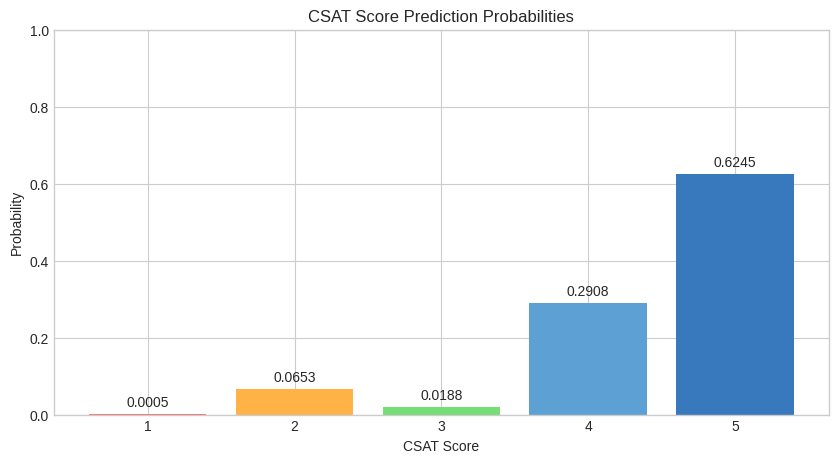

np.int64(5)

In [43]:
# Example 1: Fast response from experienced agent
predict_csat_simple(
    channel="Inbound",
    category="Returns",
    response_time=5,
    tenure=">90"
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

== DeepCSAT Prediction ==

Input Parameters:
- Channel: Email
- Category: Product Queries
- Sub-category: Refund request
- Product: Electronics
- Tenure: >90
- Shift: Morning
- Response Time: 60 minutes
- Item Price: $5000

Predicted CSAT Score: 5

Probability Distribution:
★☆☆☆☆ (CSAT 1): 0.0028
★★☆☆☆ (CSAT 2): 0.2073
★★★☆☆ (CSAT 3): 0.0417
★★★★☆ (CSAT 4): 0.3477
★★★★★ (CSAT 5): 0.4004


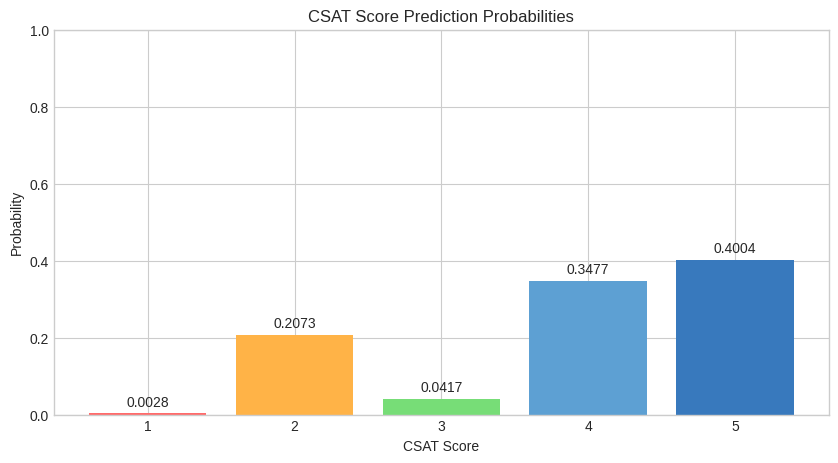

np.int64(5)

In [44]:
# Example 2: Email channel with slower response
predict_csat_simple(
    channel="Email",
    category="Product Queries",
    response_time=60
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

== DeepCSAT Prediction ==

Input Parameters:
- Channel: Inbound
- Category: Product Queries
- Sub-category: Technical issue
- Product: Electronics
- Tenure: On Job Training
- Shift: Morning
- Response Time: 30 minutes
- Item Price: $5000

Predicted CSAT Score: 5

Probability Distribution:
★☆☆☆☆ (CSAT 1): 0.0019
★★☆☆☆ (CSAT 2): 0.1572
★★★☆☆ (CSAT 3): 0.0401
★★★★☆ (CSAT 4): 0.3609
★★★★★ (CSAT 5): 0.4399


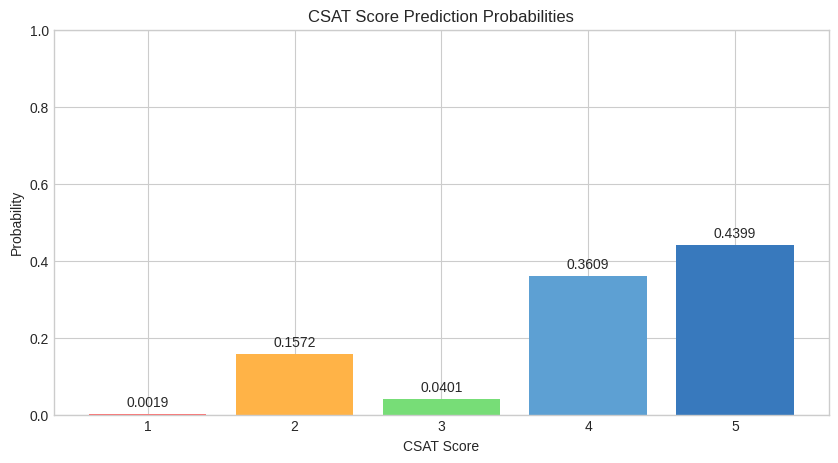

np.int64(5)

In [45]:
# Example 3: New agent handling technical issue
predict_csat_simple(
    channel="Inbound",
    category="Product Queries",
    subcategory="Technical issue",
    tenure="On Job Training",
    response_time=30
)

Business Insights and Recommendations
Based on our analysis and model predictions, here are the key insights and recommendations for improving customer satisfaction:

Key Insights
Response Time is Critical: Our analysis shows that fast response times (< 10 minutes) are strongly associated with high CSAT scores (4.43 average), while responses over 30 minutes show significantly lower satisfaction.

Channel Impact: Inbound calls achieve the highest satisfaction (4.22), while email interactions show the lowest (3.82).

Agent Experience Matters: Experienced agents (>90 days tenure) deliver significantly better satisfaction (4.29) compared to new agents (3.94).

Product Category Differences: "Lifestyle" products have the highest satisfaction (4.04), while "Home" products have the lowest (3.47).

Category-Specific Variations: "Returns" and "Offers & Cashback" categories surprisingly have high satisfaction levels despite being potentially negative interactions.

Recommendations
Implement a "10-minute response guarantee" for all customer inquiries, as this single factor could significantly improve overall CSAT scores.

Enhance email response processes by creating better templates, automated acknowledgments, and more efficient routing to reduce the channel gap.

Strengthen training for new agents with mentoring from experienced agents specifically in high-impact categories.

Focus improvement initiatives on "Home" and "Mobile" product categories where satisfaction is lowest.

Deploy real-time alerts for interactions predicted to result in low CSAT, enabling proactive service recovery.

Apply differential staffing by assigning more experienced agents to critical product categories and complex issues.

Develop category-specific service protocols based on the unique factors driving satisfaction in each interaction type.

 Future Enhancements
To further improve the DeepCSAT model and its applications, consider these enhancements:

Text Analysis: Incorporate NLP techniques to analyze customer remarks for sentiment and specific issues.

Time Series Analysis: Add temporal features to capture seasonal patterns and trends in customer satisfaction.

Agent-specific Models: Develop personalized models for different agent groups based on their experience and performance patterns.

Multi-task Learning: Extend the model to predict both CSAT and likelihood of customer return or other business metrics.

Explainable AI: Implement SHAP or LIME techniques for better model interpretability for stakeholders.

Real-time Integration: Connect the prediction model with CRM systems for live CSAT prediction during customer interactions.

Continuous Learning: Implement a system for regular model retraining as new data becomes available.



MODEL DEPLOYMENT


To deploy the DeepCSAT model in a production environment, follow these steps:

Export the Trained Model: Save both the model and preprocessor:

In [ ]:
model.save('deepcsat_model')
joblib.dump(preprocessor, 'csat_preprocessor.joblib')


Create a Prediction Service: Develop a simple API using Flask or FastAPI:

In [ ]:
from flask import Flask, request, jsonify
import tensorflow as tf
import joblib
import pandas as pd
import numpy as np

app = Flask(__name__)

# Load model and preprocessor
model = tf.keras.models.load_model('deepcsat_model')
preprocessor = joblib.load('csat_preprocessor.joblib')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    df = pd.DataFrame(data, index=[0])

    # Preprocess the data
    X_preprocessed = preprocessor.transform(df)

    # Get predictions
    predictions_prob = model.predict(X_preprocessed)
    prediction = np.argmax(predictions_prob[0]) + 1  # Convert back to 1-5 scale

    return jsonify({
        'predicted_csat': int(prediction),
        'probabilities': predictions_prob[0].tolist()
    })

if __name__ == '__main__':
    app.run(debug=True)

Containerize with Docker:

In [ ]:
FROM python:3.9-slim

WORKDIR /app

COPY requirements.txt ./
RUN pip install --no-cache-dir -r requirements.txt

COPY deepcsat_model ./deepcsat_model
COPY csat_preprocessor.joblib ./
COPY app.py ./

EXPOSE 5000

CMD ["python", "app.py"]